# 详细文档

- [detect](https://docs.ultralytics.com/modes/predict/#inference-arguments)
- [segment](https://docs.ultralytics.com/tasks/segment/)
- [classify](https://docs.ultralytics.com/tasks/classify/)
- [pose](https://docs.ultralytics.com/tasks/pose/)
- [obb](https://docs.ultralytics.com/tasks/obb/)
- [track](https://docs.ultralytics.com/modes/track/)

# 目录

- [1. 推理](#1-推理)
- [2. 绘制结果](#2-绘制结果)
  - [2.1. classify](#21-classify)
  - [2.2. detect](#22-detect)
  - [2.3. segment](#23-segment)

In [2]:
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors


cls_model = YOLO(r'F:\Projects\weights\yolo\v8\cls\yolov8m-cls.pt')
det_model = YOLO(r'F:\Projects\weights\yolo\v8\detect\coco\yolov8m.pt')
seg_model = YOLO(r'F:\Projects\weights\yolo\v8\seg\yolov8m-seg.pt')
source = r'assets\bus.jpg'

# 1. 推理

In [3]:
models = [cls_model, det_model, seg_model]

In [4]:
stream = True
result_list = []
for model in models:
    results = model.predict(
        source=source,
        imgsz=(384, 640),
        stream=stream,  # False: results=list, True: results=generator
        verbose=False
        )

    result = next(results) if stream else results[0]
    result_list.append(result)

    print(model.task)
    print(dir(model))
    print(dir(result))
    # print(result.probs) if model.task == 'classify' else None


classify
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_check_is_pytorch_model', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_hub_session', '_get_name', '_is_full_backward_hook', '_load', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_new', '_non_p

# 2. 绘制结果

In [16]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics.data.augment import LetterBox


def plot(cv_img):
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(cv_img)
    plt.axis('off')
    plt.imshow(pil_img)
    plt.show()

## 2.1. classify

## 2.2. detect

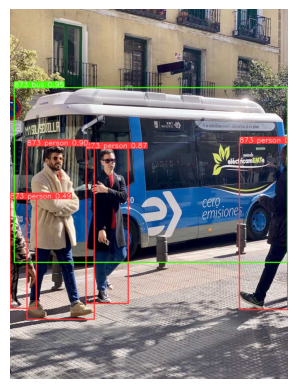

In [17]:
det_result = result_list[1]
im0 = det_result.orig_img
names = det_result.names
det = det_result.boxes.data.cpu().numpy()

annotated_frame = im0.copy()
annotator = Annotator(annotated_frame, line_width=2, example=str(names))
if len(det) and len(det[0]) == 6:  # 有目标
    for *xyxy, conf, cls in reversed(det):
        c = int(cls)  # integer class
        label = f"{int(id)} {names[c]} {conf:.2f}"
        annotator.box_label(xyxy, label, color=colors(c, True))

annotated_frame = annotator.result()
# cv2.imshow("YOLOv8 detection", annotated_frame)
# cv2.waitKey(0)

plot(annotated_frame)

## 2.3. segment

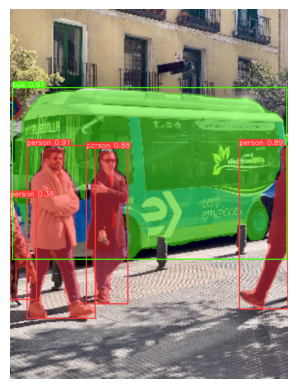

In [18]:
import torch


seg_result = result_list[2]

im0 = seg_result.orig_img
names = seg_result.names
boxes = seg_result.boxes
masks = seg_result.masks
idx = boxes.cls if boxes else range(len(masks))

annotated_frame = im0.copy()
annotator = Annotator(annotated_frame, line_width=2, example=str(names))

img = LetterBox(masks.shape[1:])(image=annotator.result())
im_gpu = (
            torch.as_tensor(img, dtype=torch.float16, device=masks.data.device)
            .permute(2, 0, 1)
            .flip(0)
            .contiguous()
            / 255
        )
annotator.masks(masks.data, colors=[colors(x, True) for x in idx], im_gpu=im_gpu)

for *xyxy, conf, cls in reversed(boxes.data.cpu().numpy()):
    c = int(cls)
    label = f"{names[c]} {conf:.2f}"
    annotator.box_label(xyxy, label, color=colors(c, True))

annotated_frame = annotator.result()
# cv2.imshow("YOLOv8 Segmentation", annotated_frame)
# cv2.waitKey(0)

plot(annotated_frame)